In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [75]:
# Define dataset path
dataset_path = r"D:\Brain_Data_Organised\Brain_Data_Organised" # Change this to your dataset path
csv_path = r"D:\Brain_Data_Organised\Brain_Data_Organised\labels.csv"

In [95]:
# Load CSV file
df = pd.read_csv(csv_path)

# Function to load and preprocess images
def load_and_preprocess_image(img_path, img_size=(224, 224)):
    img = load_img(os.path.join(dataset_path, img_path), target_size=img_size)
    img = img_to_array(img) / 255.0  # Normalize to [0,1]
    return img

# Load images and labels
X = np.array([load_and_preprocess_image(img_path) for img_path in df["filename"]])
y = np.array(df["label"])  # Labels: 1 for stroke, 0 for normal
import os
print("X shape:", X.shape)
print("X max:", X.max(), "X min:", X.min())







X shape: (1898, 224, 224, 3)
X max: 1.0 X min: 0.0


In [83]:
from PIL import Image
img = Image.open(os.path.join(dataset_path, df["filename"].iloc[0]))
img.show()


In [47]:
from tensorflow.keras.callbacks import EarlyStopping

In [102]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Split Data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define input layer
input_layer = Input(shape=(224, 224, 3))

# Load ResNet50 with Pretrained Weights
base_model = ResNet50(weights="imagenet", include_top=False, input_tensor=input_layer)
for layer in base_model.layers[:-10]:  # Freeze all but last 10 layers
    layer.trainable = False

# Build Custom Classifier
x = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(x)  # Normalization for stability
x = Dense(256, activation="relu")(x)
x = Dropout(0.4)(x)  # Regularization
output_layer = Dense(1, activation="sigmoid")(x)  # Binary classification

# Create Final Model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

# Define EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# Train Model
history = model.fit(
    X_train, y_train,
    epochs=5,  # Increase epochs since we have a stronger model
    validation_data=(X_val, y_val),
    batch_size=32,
    callbacks=[early_stopping]
)

# Save Model
model.save("stroke_classifier_resnet50.h5")


Epoch 1/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.6492 - loss: 0.7056 - val_accuracy: 0.5842 - val_loss: 0.6727
Epoch 2/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.8651 - loss: 0.2988 - val_accuracy: 0.6553 - val_loss: 0.6552
Epoch 3/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.9265 - loss: 0.1732 - val_accuracy: 0.7684 - val_loss: 0.6195
Epoch 4/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.9646 - loss: 0.0993 - val_accuracy: 0.7895 - val_loss: 0.5474
Epoch 5/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.9761 - loss: 0.0701 - val_accuracy: 0.8342 - val_loss: 0.4452
Restoring model weights from the end of the best epoch: 5.


In [103]:
y_pred = model.predict(X[:10])  # Predict on a small batch
print(y_pred)  # Check output values


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[[0.45144582]
 [0.39897576]
 [0.41191614]
 [0.40115243]
 [0.38749546]
 [0.5023941 ]
 [0.6197006 ]
 [0.6166351 ]
 [0.52456   ]
 [0.49174333]]


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step
Accuracy: 0.9263
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.93       196
           1       0.93      0.92      0.92       184

    accuracy                           0.93       380
   macro avg       0.93      0.93      0.93       380
weighted avg       0.93      0.93      0.93       380



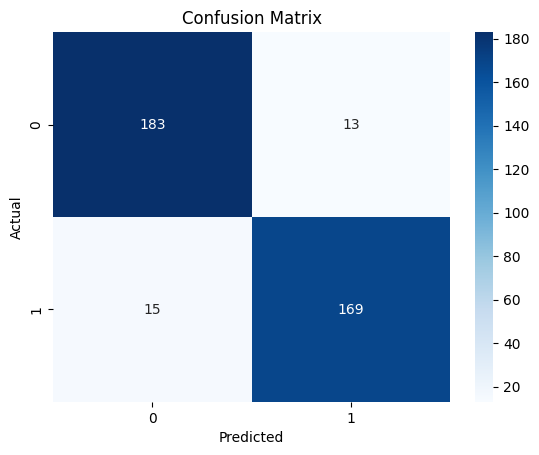

Model training complete and saved as 'stroke_classifier.h5'.


In [15]:
# Predictions
y_pred = (model.predict(X_val) > 0.5).astype("int32")

# Accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification Report
print("Classification Report:")
print(classification_report(y_val, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("Model training complete and saved as 'stroke_classifier.h5'.")


In [ ]:
import tensorflow as tf

# Load the trained model
model = tf.keras.models.load_model("stroke_classifier.h5")

# Print model summary
model.summary()

print("Model loaded successfully.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


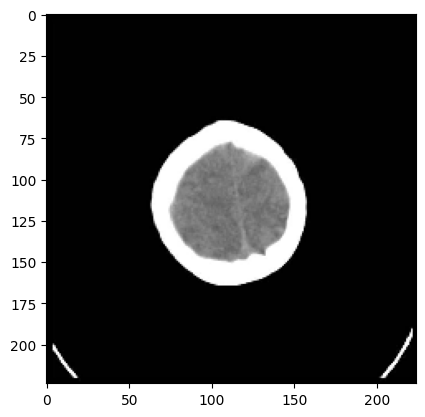

Predicted class: 0


In [49]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt


# Load the image you want to test (replace with your image's path)
img_path = r"D:\Brain_Data_Organised\Brain_Data_Organised\Stroke\66 (40).jpg"

# Preprocess the image (resize it to match the model input size, typically 224x224 for many CNNs)
img = image.load_img(img_path, target_size=(224, 224))  # adjust target_size as per your model input shape

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Reshape the array to match the model's expected input shape (add batch dimension)
img_array = np.expand_dims(img_array, axis=0)

# Normalize the image if your model was trained with normalized images (e.g., between 0 and 1)
img_array = img_array / 255.0

# Make a prediction
predictions = model.predict(img_array)

# Output the prediction (for classification tasks, you can get the class with np.argmax())
predicted_class = np.argmax(predictions)

# Display the image
plt.imshow(img)
plt.show()

# Print the predicted class
print(f"Predicted class: {predicted_class}")
